In [5]:
!pip install memory_profiler


In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import shap
import time
from memory_profiler import memory_usage


In [7]:
# Load data
df = pd.read_csv(r'/content/Video_Games.csv')

# Data Exploration
print(df.head(5))
print(df.describe())
print(df.info())
print(df.isnull().sum())
print(df.shape)


                       Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count User_Score  User_Count Developer Rating 

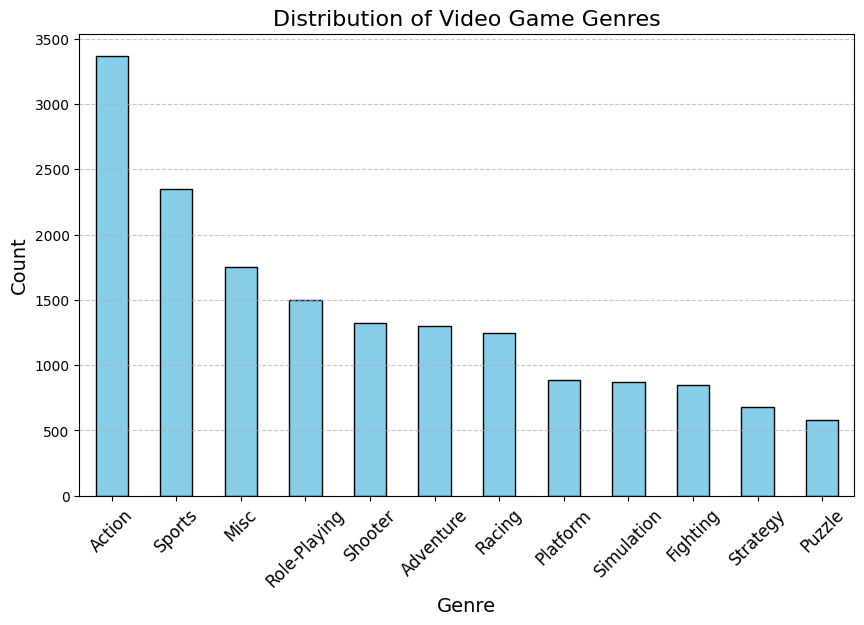

In [8]:
# Distribution of Genres
plt.figure(figsize=(10, 6))
df['Genre'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Video Game Genres', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


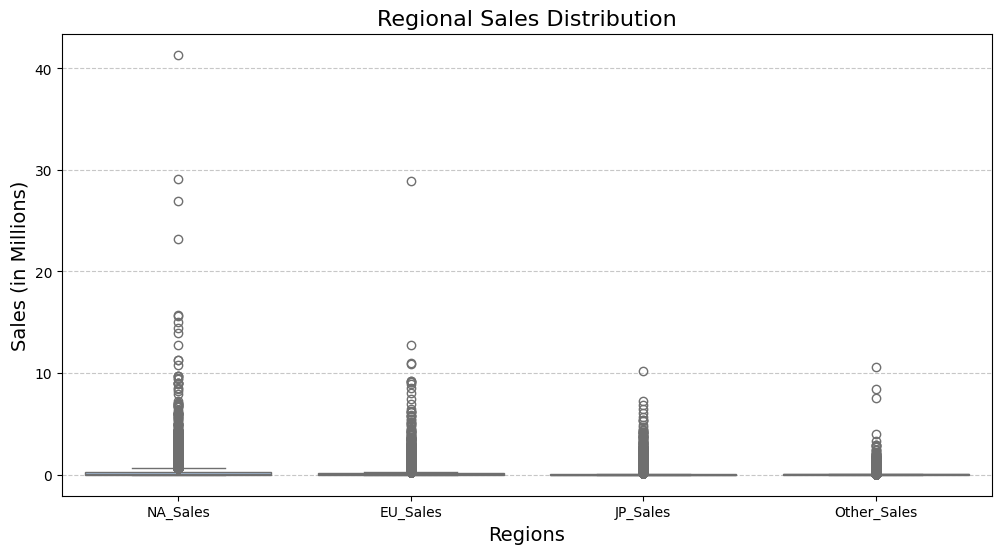

In [9]:
# Sales Distribution by Region
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[sales_columns], palette='pastel')
plt.title('Regional Sales Distribution', fontsize=16)
plt.xlabel('Regions', fontsize=14)
plt.ylabel('Sales (in Millions)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


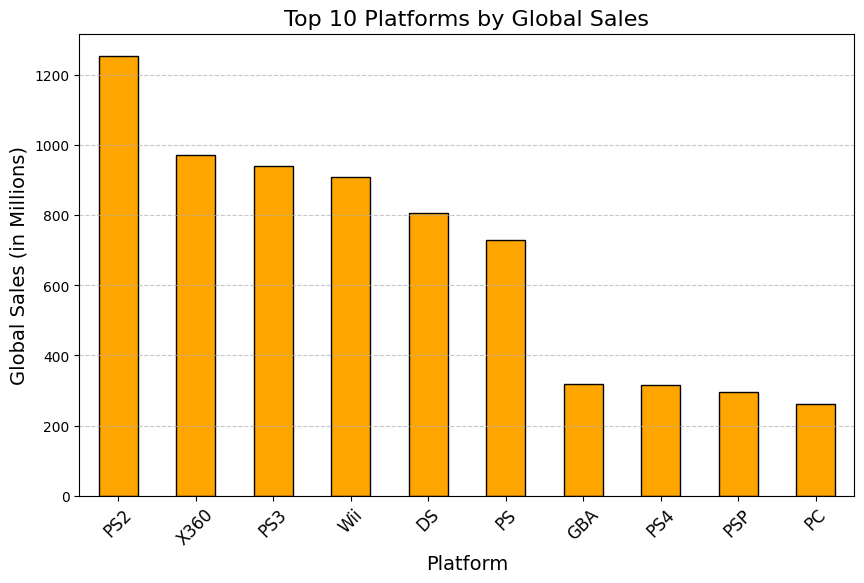

In [10]:
# Global Sales by Platform
platform_sales = df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
platform_sales.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Platforms by Global Sales', fontsize=16)
plt.xlabel('Platform', fontsize=14)
plt.ylabel('Global Sales (in Millions)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<ipython-input-11-e4ba98ff6143>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Platform', palette='viridis')


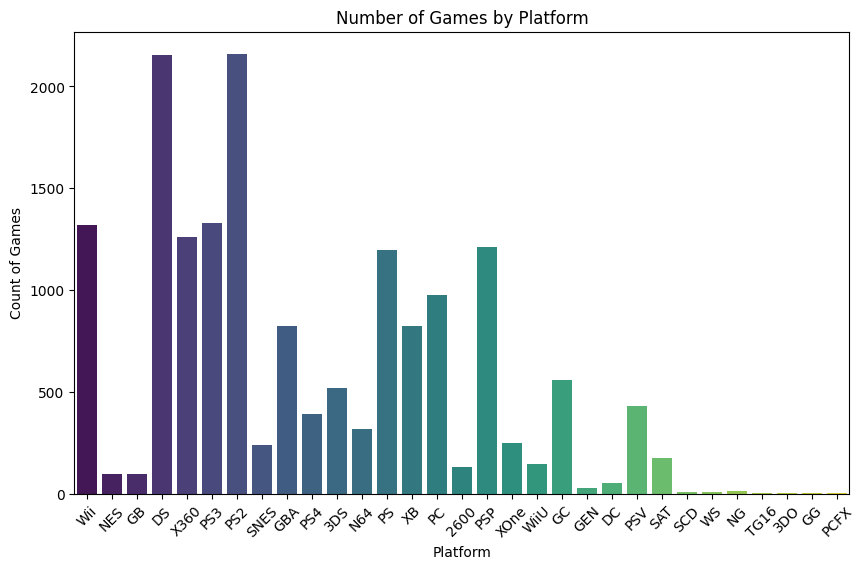

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Platform', palette='viridis')
plt.title('Number of Games by Platform')
plt.xlabel('Platform')
plt.ylabel('Count of Games')
plt.xticks(rotation=45)
plt.show()

In [12]:
# preprocessing
df['NA_Sales'] = pd.to_numeric(df['NA_Sales'], errors='coerce').astype('float32')
df['EU_Sales'] = pd.to_numeric(df['EU_Sales'], errors='coerce').astype('float32')
df['JP_Sales'] = pd.to_numeric(df['JP_Sales'], errors='coerce').astype('float32')
df['Other_Sales'] = pd.to_numeric(df['Other_Sales'], errors='coerce').astype('float32')
df['Global_Sales'] = pd.to_numeric(df['Global_Sales'], errors='coerce').astype('float32')

In [13]:
# Handling missing values
nan_df = df[df.isna().any(axis=1)]
df = df.dropna()  # Dropping NaN values
print(f"Original dataset shape: {df.shape}")
print(f"NaN dataset shape: {nan_df.shape}")
print(f"Number of rows dropped (containing NaN Values): {df.shape[0] - nan_df.shape[0]}")

Original dataset shape: (6825, 16)
NaN dataset shape: (9894, 16)
Number of rows dropped (containing NaN Values): -3069


In [14]:
# Factorizing categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df1 = df.copy()
for col in cat_cols:
    df1[col] = pd.factorize(df[col])[0]


In [15]:
# Splitting data into features and target variable
X = df1.drop(['Name', 'Publisher', 'Developer', 'Global_Sales'], axis=1)
y = df1['Global_Sales']

In [16]:
# Apply StandardScaler for normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [18]:
# Model Training
model = HistGradientBoostingRegressor(random_state=42)

In [19]:
# Hyperparameter Tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [10, 20, 50]
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 300, 'min_samples_leaf': 10}


In [20]:
# Training
model = grid_search.best_estimator_
start = time.time()
model.fit(X_train_selected, y_train)
print(f"Training time: {time.time() - start:.2f} seconds")


Training time: 0.42 seconds


In [21]:
# Predictions
y_pred = model.predict(X_test_selected)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [22]:
# Displaying metrics
print(f'R² Score: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

R² Score: 0.96
RMSE: 0.31
Mean Absolute Error (MAE): 0.08


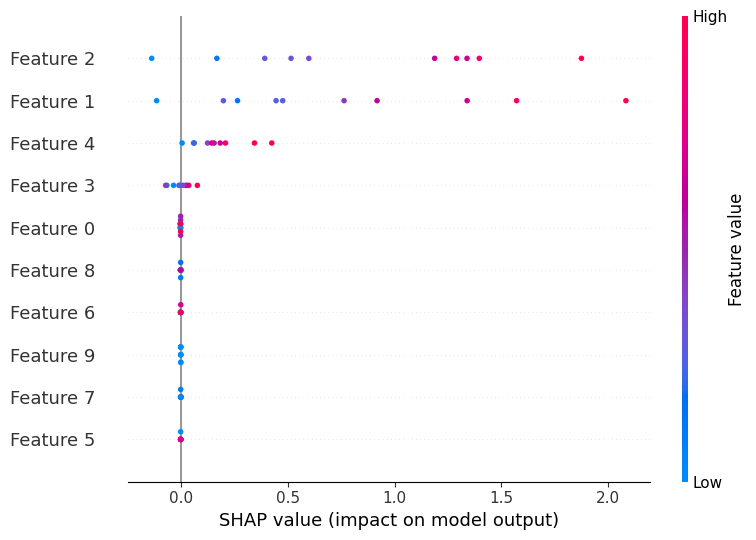

In [23]:
# SHAP Values
X_train_shap = shap.kmeans(X_train_selected, 10)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_shap.data)
shap.summary_plot(shap_values, X_train_shap.data)


In [24]:
# Model Memory Usage
def train_model():
    model.fit(X_train_selected, y_train)
mem_usage = memory_usage(train_model)
print(f"Max memory usage: {max(mem_usage)} MB")


Max memory usage: 401.6484375 MB


In [25]:
threshold = 0.5
accuracy_within_threshold = np.mean(np.abs((y_test - y_pred) / y_test) < threshold)
print(f"Accuracy : {accuracy_within_threshold:.2f}")


Accuracy : 0.80


In [26]:
# SHAP values
print("SHAP values for the first sample:")
print(shap_values[0])


SHAP values for the first sample:
[-6.59631057e-05 -1.12537083e-01 -1.35445854e-01 -3.33091816e-02
  6.65431482e-03 -9.84577888e-05 -5.48925654e-04  6.35865529e-05
  5.63061027e-04  9.29316924e-06]


In [27]:
import time
start = time.time()
model.fit(X_train, y_train)
print(f"Training time: {time.time() - start:.2f} seconds")

Training time: 0.49 seconds


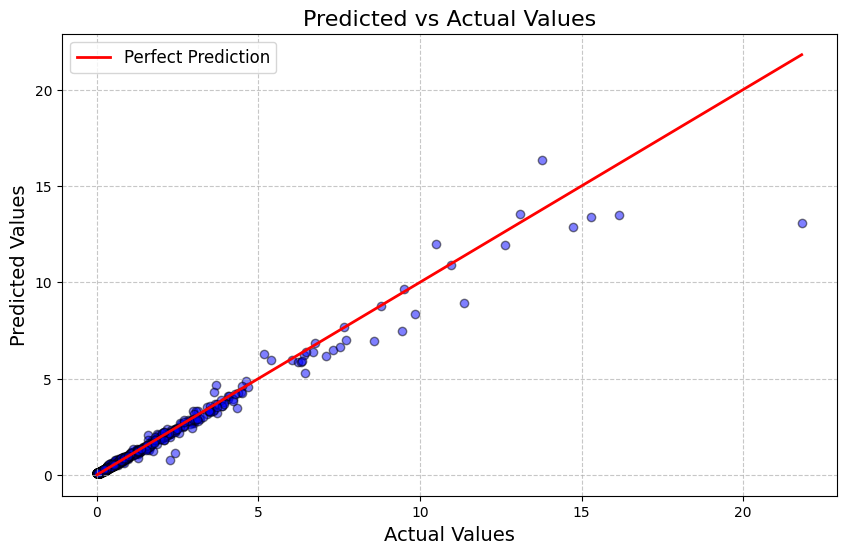

In [28]:
# Scatter plot for accuracy
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, edgecolor='k')
plt.title('Predicted vs Actual Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction')
plt.legend(fontsize=12)
plt.show()
